In [16]:
# This is the project code.

In [10]:
#Imports and important setup

import pyspark
from delta import *

import os
from pathlib import Path
import datetime
import pandas as pd
import json
import numpy as np
import shapely
from shapely import Point
from shapely.geometry import mapping, shape
import pyspark.sql.functions as F
from pyspark.sql import Window
from shapely import Polygon
from pyspark.sql.functions import col, count, when, unix_timestamp, lead, avg, round
from pyspark.sql.types import DoubleType, IntegerType, StringType, StructField, StructType, TimestampType
from shapely.strtree import STRtree
import matplotlib.pyplot as plt
import logging

logging.basicConfig(
    format="%(asctime)s %(message)s",
    level=logging.INFO
)
#https://stackoverflow.com/questions/50873446/python-logger-output-dates-in-is8601-format
logging.Formatter.formatTime = (lambda self, record, datefmt=None: datetime.datetime.fromtimestamp(record.created, datetime.timezone.utc).astimezone().isoformat(sep="T",timespec="milliseconds"))

processingMode = "real"
#processingMode = "test"

rootfolder = "trip_data"
filenames = ["trip_data_1.csv","trip_data_2.csv","trip_data_3.csv","trip_data_4.csv","trip_data_5.csv","trip_data_6.csv","trip_data_7.csv","trip_data_8.csv","trip_data_9.csv","trip_data_10.csv","trip_data_11.csv","trip_data_12.csv"]

#rootfolder = "trip"
#filenames = ["sample.csv"]

outfolderSegments = ["results",processingMode]
plotsfolderSegments = ["plots",processingMode]

plotsfolder = os.sep.join(plotsfolderSegments)
outfolder = os.sep.join(outfolderSegments)

aggregatedResultsFolder = "aggregated"

builder = pyspark.sql.SparkSession.builder.appName("Project1") \
    .config("spark.sql.extensions", "io.delta.sql.DeltaSparkSessionExtension") \
    .config("spark.sql.catalog.spark_catalog", "org.apache.spark.sql.delta.catalog.DeltaCatalog") 

spark = configure_spark_with_delta_pip(builder).getOrCreate()
spark.sparkContext.setCheckpointDir(os.sep.join(["checkpoints",processingMode]))

## Process data

In [ ]:
#Schema definition
dataSchema = StructType([
    StructField("medallion",StringType(),True),
    StructField("hack_license",StringType(),True),
    StructField("vendor_id",StringType(),True),
    StructField("rate_code",IntegerType(),True),
    StructField("store_and_fwd_flag",StringType(),True),
    StructField("pickup_datetime",TimestampType(),True),
    StructField("dropoff_datetime",TimestampType(),True),
    StructField("passenger_count",IntegerType(),True),
    StructField("trip_time_in_secs",IntegerType(),True),
    StructField("trip_distance",DoubleType(),True),
    StructField("pickup_longitude",DoubleType(),True),
    StructField("pickup_latitude",DoubleType(),True),
    StructField("dropoff_longitude",DoubleType(),True),
    StructField("dropoff_latitude",DoubleType(),True),
])  
logging.info("Reading in general borough geojson")
# Reading in borough dataset
with open('nyc-boroughs.geojson') as file:
    boroughs = json.load(file)

features = boroughs['features']
properties = [feature['properties'] for feature in features]
geometry = [feature['geometry'] for feature in features]

rowNumberWindow = Window.orderBy(F.lit("a"))

properties_df = spark.createDataFrame(properties).withColumn("rid",F.row_number().over(rowNumberWindow))
geometry_df = spark.createDataFrame(geometry).withColumn("rid",F.row_number().over(rowNumberWindow))
borough_base_df = properties_df.join(geometry_df,("rid")).drop("rid") #rid - row_id

for index, filename in enumerate(filenames):
    logging.info(f"Starting processing of file: {filename} . Progress: {((index) / len(filenames) * 100)}%")
    fileNamePart, fileTypePart, *_restParts = filename.split(".csv")

    # Reading in taxi dataset
    taxiDataDf = (spark.read
                .option("sep", ",") # separator
                .option("header", True) # file has header row
                .schema(dataSchema) # Using pre specified path for 
                .csv(os.path.join(rootfolder,filename)) #path
                ) \
                .dropna(subset=["pickup_datetime","dropoff_datetime","pickup_longitude","pickup_latitude","dropoff_longitude","dropoff_latitude"]) \
                .drop("vendor_id","rate_code","store_and_fwd_flag") #Dropping columns we don't need and removing those rows where nulls exist

    #--------------------------------------


    # Finding the area size of the boroughs
    def calculate_area(coordinates):
        polygon = Polygon(list(coordinates[0]))
        return polygon.area

    calculate_area_udf = F.udf(calculate_area,DoubleType())

    borough_df_sorted = borough_base_df.withColumn("area",calculate_area_udf(F.col("coordinates"))) \
                                .sort(F.col("area").desc()) \
                                .withColumn("row_id",F.row_number().over(rowNumberWindow) - 1)


    # https://shapely.readthedocs.io/en/stable/strtree.html
    # This tree is used to speed up finding the nearest bourough based on given point coordinates
    geomtree = STRtree([Polygon(coords["coordinates"][0]) for coords in borough_df_sorted.select("coordinates").collect()])

    def findBorough(x,y):
        """
            This will find the latest borough index based on given coordinates
        """
        point = Point(x,y)
        nearestLocIndex = geomtree.nearest(point)
        return nearestLocIndex


    #--------------------------------------

    # Define a function to find the point borough
    def update_borough(longitude, latitude):
        borough = findBorough(longitude, latitude)
        return int(borough) if borough is not None else -1

    # Create a user-defined function (UDF)
    update_borough_udf = F.udf(update_borough, IntegerType())

    logging.info("Applying UDFs")
    # Apply the UDF to update the start and end borough column (finding the borough index)
    taxiDataDf_with_boroughs = taxiDataDf.withColumn("startBoroughIndex", update_borough_udf(taxiDataDf["pickup_longitude"], taxiDataDf["pickup_latitude"]))
    taxiDataDf_with_boroughs = taxiDataDf_with_boroughs.withColumn("endBoroughIndex", update_borough_udf(taxiDataDf["dropoff_longitude"], taxiDataDf["dropoff_latitude"]))

    #Adding actual borough names back based on index. Many index values can have the same borough name
    taxiDataDf_with_boroughs = taxiDataDf_with_boroughs.join(borough_df_sorted,taxiDataDf_with_boroughs.startBoroughIndex == borough_df_sorted.row_id,"left").drop("@id","coordinates","type","area","row_id").withColumnRenamed("borough","startBorough").withColumnRenamed("boroughCode","startBoroughCode")
    taxiDataDf_with_boroughs = taxiDataDf_with_boroughs.join(borough_df_sorted,taxiDataDf_with_boroughs.endBoroughIndex == borough_df_sorted.row_id,"left").drop("@id","coordinates","type","area","row_id").withColumnRenamed("borough","endBorough").withColumnRenamed("boroughCode","endBoroughCode")

    logging.info("Creating checkpoint before query 1")
    #Checkpoint here to truncate the query plan and make computing in the following steps easier
    taxiDataDf_with_boroughs = taxiDataDf_with_boroughs.checkpoint()
    logging.info("Checkpoint created")

    #-------------------------------QUERY 1-------------------------------#

    taxiUtilizationBaseDf = taxiDataDf_with_boroughs.filter("trip_time_in_secs > 0 or trip_time_in_secs <= 3600 * 4")
                

    utilizationWindow = Window.partitionBy("hack_license").orderBy("pickup_datetime")

    idleTimeDf = taxiUtilizationBaseDf.withColumn("idle_time",(F.col("pickup_datetime") - F.lag(F.col("dropoff_datetime")).over(utilizationWindow)).cast("long")) \
                                    .fillna(0,subset=["idle_time"]).filter("idle_time <= 3600*4")

    query1_df = idleTimeDf.groupBy("hack_license").agg(F.sum("idle_time").alias("idle_time_sum_seconds"))
    
    #Save result to file
    query1_df.coalesce(1).write.mode("overwrite").csv(os.sep.join([outfolder,fileNamePart,"query1.csv"]),header=True)

    # Plotting the results

    pandas_query1_df = query1_df.toPandas()
    idle_time = pandas_query1_df.get("idle_time_sum_seconds")
    idle_time_minutes = [ int(x/60) for x in idle_time]

    # NB! Over 1000 minutes is missing!!!
    fig = plt.figure(figsize = (7, 4))

    bins= [0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000] # NB! Over 1000 minutes values are missing!!!
    plt.hist(idle_time_minutes, bins=bins, color="#82c7a5ff")
    plt.xticks(bins)
    plt.xlabel("Idle time (minutes)")
    plt.ylabel("Count")
    plt.title("New York City Taxi Drivers idle times in minutes - " + filename)
    figfolder = os.sep.join([plotsfolder,fileNamePart])
    Path(figfolder).mkdir(exist_ok=True, parents=True)
    plt.savefig(fname=os.sep.join([figfolder,"q1.png"]))
    plt.savefig(fname=os.sep.join([figfolder,"q1.svg"]))

    logging.info("Query 1 completed")

    #-------------------------------QUERY 2-------------------------------#

    windowSpec = Window.partitionBy("hack_license").orderBy("dropoff_datetime")

    df = taxiDataDf_with_boroughs.withColumn("next_pickup_time", lead("pickup_datetime").over(windowSpec))
    df = df.withColumn("time_to_next_fare", unix_timestamp("next_pickup_time") - unix_timestamp("dropoff_datetime"))
    df = df.filter((col("time_to_next_fare") >= 0) & (col("time_to_next_fare") <= 3600*4))  

    avg_wait_time_per_borough = df.groupBy("endBorough").agg(round(avg("time_to_next_fare") / 60 , 2).alias("avg_waiting_time_minutes"))
    avg_wait_time_per_borough.coalesce(1).write.mode("overwrite").csv(os.sep.join([outfolder,fileNamePart,"query2.csv"]),header=True)

    # Plotting the query2
    pandas_query2_df = avg_wait_time_per_borough.toPandas()

    fig = plt.figure(figsize = (6, 3))

    # function to add value labels
    def addlabels(x,y):
        for i in range(len(x)):
            plt.text(i, y[i], y[i], ha = 'center')

    x = pandas_query2_df.get("endBorough")
    y = pandas_query2_df.get("avg_waiting_time_minutes")
    # creating the bar plot
    plt.bar(x, y, color ='#a4c2f4ff')

    addlabels(x, y)
    plt.xlabel("Borough name")
    plt.ylabel("Average wait time")
    plt.title("Average wait time per borough - " + filename)
    figfolder = os.sep.join([plotsfolder,fileNamePart])
    Path(figfolder).mkdir(exist_ok=True, parents=True)
    plt.savefig(fname=os.sep.join([figfolder,"q2.png"]))
    plt.savefig(fname=os.sep.join([figfolder,"q2.svg"]))

    logging.info("Query 2 completed")
    #-------------------------------QUERY 3-------------------------------#
    same_borough_df = taxiDataDf_with_boroughs.filter(F.col("startBoroughCode") == F.col("endBoroughCode"))
    logging.info("The number of trips that start and end in the same borough is " + str(same_borough_df.count()) + ".")

    query3_df = same_borough_df.groupBy("startBorough").count()

    #Write the results to file
    query3_df.coalesce(1).write.mode("overwrite").csv(os.sep.join([outfolder,fileNamePart,"query3.csv"]),header=True)

    # Plotting the query3 results
    query3_df_pandas = query3_df.toPandas()

    fig = plt.figure(figsize = (5, 3))

    # function to add value labels
    def addlabels(x,y):
        for i in range(len(x)):
            plt.text(i, y[i], y[i], ha = 'center')

    x = query3_df_pandas.get("startBorough")
    y = query3_df_pandas.get("count")
    # creating the bar plot
    plt.bar(x, y, color ='#82c7a5ff')

    addlabels(x, y)
    plt.xlabel("Borough name")
    plt.ylabel("Count")
    plt.title("Number of trips started and ended in the same borough - " + filename)
    figfolder = os.sep.join([plotsfolder,fileNamePart])
    Path(figfolder).mkdir(exist_ok=True, parents=True)
    plt.savefig(fname=os.sep.join([figfolder,"q3.png"]))
    plt.savefig(fname=os.sep.join([figfolder,"q3.svg"]))


    logging.info("Query 3 completed")
    #-------------------------------QUERY 4-------------------------------#
    different_borough_df = taxiDataDf_with_boroughs.filter(F.col("startBoroughCode") != F.col("endBoroughCode"))
    logging.info("The number of trips that have different start and end borough is " + str(different_borough_df.count()) + ".")

    query4_start_df = different_borough_df.groupBy("startBorough").count()

    #Save results to file
    query4_start_df.coalesce(1).write.mode("overwrite").csv(os.sep.join([outfolder,fileNamePart,"query4.csv"]),header=True)

    # Plotting the query4 results (start borough)
    query4_start_df_pandas = query4_start_df.toPandas()

    fig = plt.figure(figsize = (7, 3))

    # function to add value labels
    def addlabels(x,y):
        for i in range(len(x)):
            plt.text(i, y[i], y[i], ha = 'center')

    x = query4_start_df_pandas.get("startBorough")
    y = query4_start_df_pandas.get("count")
    # creating the bar plot
    plt.bar(x, y, color ='#a4c2f4ff', width=0.4)

    addlabels(x, y)
    plt.xlabel("Borough name")
    plt.ylabel("Count")
    plt.title("Number of trips started and ended in a different borough (per start borough) - " + filename)
    figfolder = os.sep.join([plotsfolder,fileNamePart])
    Path(figfolder).mkdir(exist_ok=True, parents=True)
    plt.savefig(fname=os.sep.join([figfolder,"q4.png"]))
    plt.savefig(fname=os.sep.join([figfolder,"q4.svg"]))


    logging.info("Query 4 completed")
    print("\n")



## Query 1: Utilization

Utilization: This is per taxi/driver. This can be computed by computing the idle 
time per taxi. We will elaborate on that more later

In [11]:
query1Schema = StructType([
    StructField("hack_license",StringType(),True),
    StructField("idle_time_sum_seconds",IntegerType(),True),
])

generalQuery1Df = spark.createDataFrame(spark.sparkContext.emptyRDD(),query1Schema)

for fullFileName in filenames:
    filename = fullFileName.split(".csv")[0]
    currentDf = (spark.read
                .option("sep", ",") # separator
                .option("header", True) # file has header row
                .schema(query1Schema) # Using pre specified path for 
                .csv(os.path.join(outfolder,filename,"query1.csv")) #path
                )
    generalQuery1Df = generalQuery1Df.union(currentDf)

In [23]:
aggregatedQuery1Df = generalQuery1Df.groupBy("hack_license").agg((F.sum("idle_time_sum_seconds") / 60 / 60 / 24).alias("idle_time_days"),F.sum("idle_time_sum_seconds"))
#Save result to file
aggregatedQuery1Df.coalesce(1).write.mode("overwrite").csv(os.path.join(outfolder,aggregatedResultsFolder,"query1.csv"),header=True)


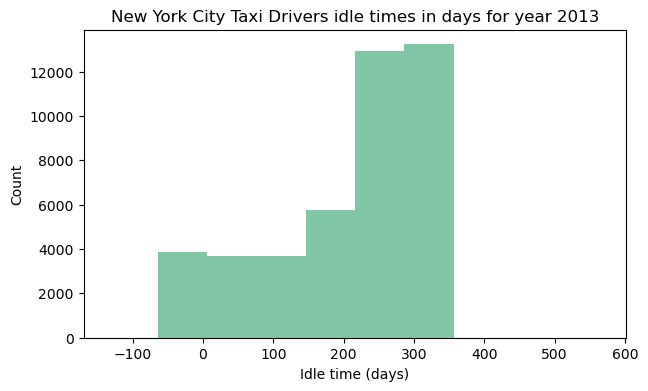

In [24]:
# Plotting the results

pandas_query1_df = aggregatedQuery1Df.toPandas()
idle_time = pandas_query1_df.get("idle_time_days")

fig = plt.figure(figsize = (7, 4))

plt.hist(idle_time, color="#82c7a5ff")
plt.xlabel("Idle time (days)")
plt.ylabel("Count")
plt.title("New York City Taxi Drivers idle times in days for year 2013")
figfolder = os.path.join(outfolder,aggregatedResultsFolder,"plots")
Path(figfolder).mkdir(exist_ok=True, parents=True)
plt.savefig(fname=os.sep.join([figfolder,"q1.png"]))
plt.savefig(fname=os.sep.join([figfolder,"q1.svg"]))

## Query 2: Average next trip time

The average time it takes for a taxi to find its next fare(trip) per destination borough. This can be computed by finding the time difference, e.g. in seconds, between the trip's drop off and the next trip's pick up.


In [28]:
query2Schema = StructType([
    StructField("endBorough",StringType(),True),
    StructField("avg_waiting_time_minutes",DoubleType(),True),
])

generalQuery2Df = spark.createDataFrame(spark.sparkContext.emptyRDD(),query2Schema)

for fullFileName in filenames:
    filename = fullFileName.split(".csv")[0]
    currentDf = (spark.read
                .option("sep", ",") # separator
                .option("header", True) # file has header row
                .schema(query2Schema) # Using pre specified path for 
                .csv(os.path.join(outfolder,filename,"query2.csv")) #path
                )
    generalQuery2Df = generalQuery2Df.union(currentDf)

In [29]:
aggregatedQuery2Df = generalQuery2Df.groupBy("endBorough").agg((F.sum("avg_waiting_time_minutes") / 60).alias("avg_waiting_time_hours"),F.sum("avg_waiting_time_minutes"))
#Save result to file
aggregatedQuery2Df.coalesce(1).write.mode("overwrite").csv(os.path.join(outfolder,aggregatedResultsFolder,"query2.csv"),header=True)


      endBorough  avg_waiting_time_hours  sum(avg_waiting_time_minutes)
0         Queens                6.343667                         380.62
1       Brooklyn                4.386833                         263.21
2  Staten Island                9.136167                         548.17
3      Manhattan                1.980667                         118.84
4          Bronx                6.867167                         412.03


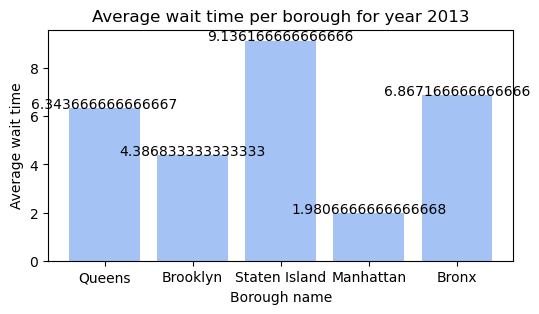

In [32]:
# Plotting the query2
pandas_query2_df = aggregatedQuery2Df.toPandas()
print(pandas_query2_df)
fig = plt.figure(figsize = (6, 3))

# function to add value labels
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i], y[i], ha = 'center')

x = pandas_query2_df.get("endBorough")
y = pandas_query2_df.get("avg_waiting_time_hours")
# creating the bar plot
plt.bar(x, y, color ='#a4c2f4ff')

addlabels(x, y)
plt.xlabel("Borough name")
plt.ylabel("Average wait time")
plt.title("Average wait time per borough for year 2013")
figfolder = os.path.join(outfolder,aggregatedResultsFolder,"plots")
Path(figfolder).mkdir(exist_ok=True, parents=True)
plt.savefig(fname=os.sep.join([figfolder,"q2.png"]))
plt.savefig(fname=os.sep.join([figfolder,"q2.svg"]))

## Query 3: Trips started in one borough

The number of trips that started and ended within the same borough,


In [35]:
query3Schema = StructType([
    StructField("startBorough",StringType(),True),
    StructField("count",IntegerType(),True),
])

generalQuery3Df = spark.createDataFrame(spark.sparkContext.emptyRDD(),query3Schema)

for fullFileName in filenames:
    filename = fullFileName.split(".csv")[0]
    currentDf = (spark.read
                .option("sep", ",") # separator
                .option("header", True) # file has header row
                .schema(query3Schema) # Using pre specified path for 
                .csv(os.path.join(outfolder,filename,"query3.csv")) #path
                )
    generalQuery3Df = generalQuery3Df.union(currentDf)

In [38]:
aggregatedQuery3Df = generalQuery3Df.groupBy("startBorough").agg((F.sum("count")).alias("agg_count"))
#Save result to file
aggregatedQuery3Df.coalesce(1).write.mode("overwrite").csv(os.path.join(outfolder,aggregatedResultsFolder,"query3.csv"),header=True)


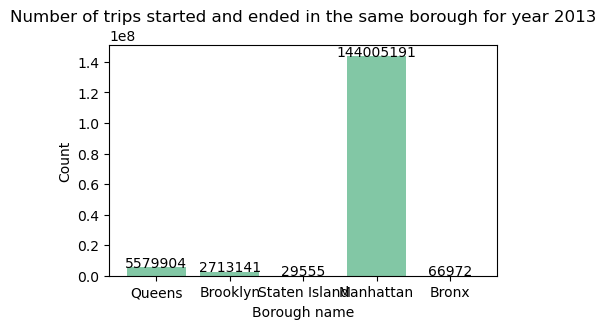

In [39]:
# Plotting the query3 results
query3_df_pandas = aggregatedQuery3Df.toPandas()

fig = plt.figure(figsize = (5, 3))

# function to add value labels
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i], y[i], ha = 'center')

x = query3_df_pandas.get("startBorough")
y = query3_df_pandas.get("agg_count")
# creating the bar plot
plt.bar(x, y, color ='#82c7a5ff')

addlabels(x, y)
plt.xlabel("Borough name")
plt.ylabel("Count")
plt.title("Number of trips started and ended in the same borough for year 2013")
figfolder = os.path.join(outfolder,aggregatedResultsFolder,"plots")
Path(figfolder).mkdir(exist_ok=True, parents=True)
plt.savefig(fname=os.sep.join([figfolder,"q3.png"]))
plt.savefig(fname=os.sep.join([figfolder,"q3.svg"]))


## Query 4: Trips between different boroughs

The number of trips that started in one borough and ended in another one

In [40]:
query4Schema = StructType([
    StructField("startBorough",StringType(),True),
    StructField("count",IntegerType(),True),
])

generalQuery4Df = spark.createDataFrame(spark.sparkContext.emptyRDD(),query3Schema)

for fullFileName in filenames:
    filename = fullFileName.split(".csv")[0]
    currentDf = (spark.read
                .option("sep", ",") # separator
                .option("header", True) # file has header row
                .schema(query4Schema) # Using pre specified path for 
                .csv(os.path.join(outfolder,filename,"query4.csv")) #path
                )
    generalQuery4Df = generalQuery4Df.union(currentDf)

In [41]:
aggregatedQuery4Df = generalQuery4Df.groupBy("startBorough").agg((F.sum("count")).alias("agg_count"))
#Save result to file
aggregatedQuery4Df.coalesce(1).write.mode("overwrite").csv(os.path.join(outfolder,aggregatedResultsFolder,"query4.csv"),header=True)


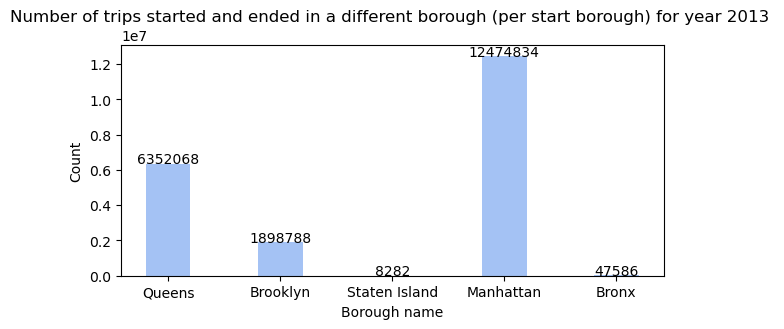

In [43]:
# Plotting the query4 results (start borough)
query4_start_df_pandas = aggregatedQuery4Df.toPandas()

fig = plt.figure(figsize = (7, 3))

# function to add value labels
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i], y[i], ha = 'center')

x = query4_start_df_pandas.get("startBorough")
y = query4_start_df_pandas.get("agg_count")
# creating the bar plot
plt.bar(x, y, color ='#a4c2f4ff', width=0.4)

addlabels(x, y)
plt.xlabel("Borough name")
plt.ylabel("Count")
plt.title("Number of trips started and ended in a different borough (per start borough) for year 2013 ")
figfolder = os.path.join(outfolder,aggregatedResultsFolder,"plots")
Path(figfolder).mkdir(exist_ok=True, parents=True)
plt.savefig(fname=os.sep.join([figfolder,"q4.png"]))
plt.savefig(fname=os.sep.join([figfolder,"q4.svg"]))
